#Financial Risk Modeling Assessment

Author: Janani Ranasinghe | jranasinghe40@gmail.com 

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import shap

In [4]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

##  STEP 1: DATA LOADING AND INITIAL EXPLORATION

In [5]:
filepath='/content/drive/MyDrive/data/loan_dataset.xlsx'

In [6]:
df = pd.read_excel(filepath)


In [7]:
print(f"\nDataset Shape: {df.shape}")


Dataset Shape: (20000, 34)


In [8]:
print(f"Features: {df.shape[1]}, Samples: {df.shape[0]}")

Features: 34, Samples: 20000


In [9]:
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,TotalLiabilities,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-06-18,37,36562,553,Employed,High School,14,38934,48,Married,...,9589,49.207,4,2603208,257.434,22.178,1230.4,6.605,1,42.4
1,2054-02-27,77,84454,676,Unemployed,Bachelor,55,9856,36,Divorced,...,20691,9.744,6,2598936,156.856,1.482,3408.1,14.462,1,30.4
2,2059-01-20,36,55540,614,Employed,High School,11,21670,12,Married,...,33311,8.786,3,2108279,17.967,21.558,2023.5,5.968,1,34.4
3,2042-09-07,28,88051,523,Employed,Associate,7,17982,36,Married,...,24934,8.834,1,2106873,241.482,27.021,734.3,20.842,1,33.6
4,2032-01-08,23,21775,581,Employed,Bachelor,3,67419,36,Married,...,34883,674.315,5,2088949,261.919,2.613,2721.1,1.820,0,44.0


In [10]:
print(df.dtypes.value_counts())

int64      21
float64     7
object      6
Name: count, dtype: int64


In [11]:
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values detected")

No missing values detected


In [12]:
print(df['LoanApproved'].value_counts())

LoanApproved
0    15220
1     4780
Name: count, dtype: int64


In [13]:
print(f"\nRiskScore Statistics:\n{df['RiskScore'].describe()}")


RiskScore Statistics:
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
Name: RiskScore, dtype: float64


The RiskScore distribution shows that most customers fall around a moderate risk level (mean ≈ 50.8).

Scores range from 28.8 to 84, with a relatively tight spread (std ≈ 7.8), meaning risk levels don’t vary extremely across customers.

The median of 52 indicates the dataset is fairly balanced without strong skew.

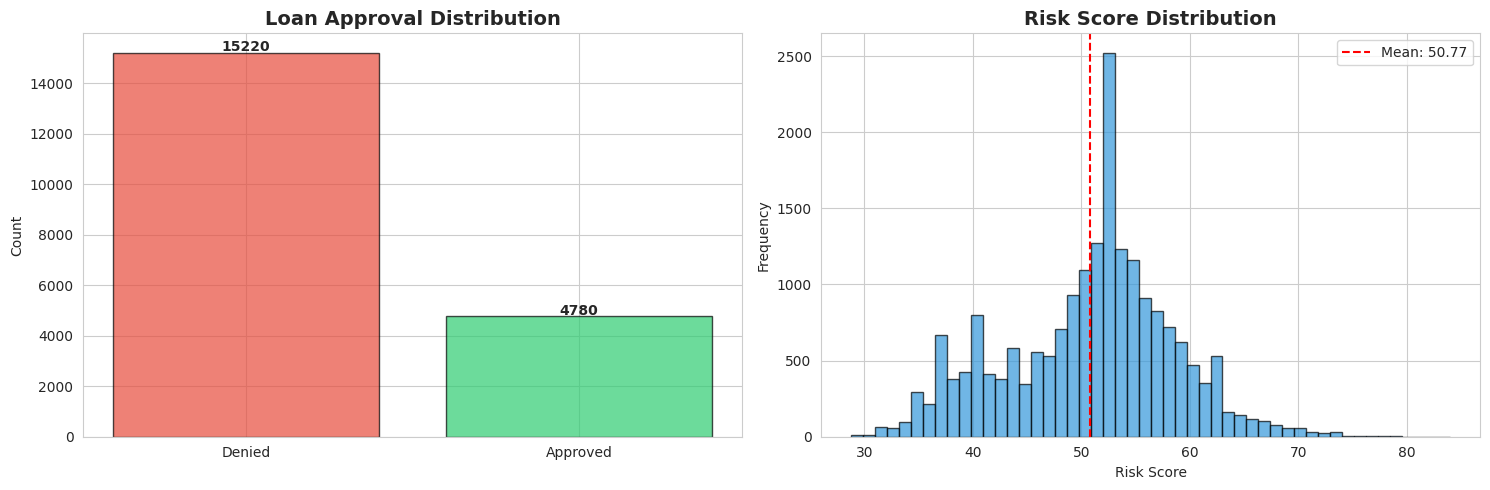

In [14]:
# Visualize target variable distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loan Approval Distribution
approval_counts = df['LoanApproved'].value_counts()
axes[0].bar(['Denied', 'Approved'], approval_counts.values,
            color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_title('Loan Approval Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(approval_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Risk Score Distribution
axes[1].hist(df['RiskScore'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Score')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['RiskScore'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["RiskScore"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()


**Loan Approval Distribution**

The dataset is heavily imbalanced — most applications were denied (15,220), while only 4,780 were approved. This suggests stricter approval criteria and indicates that the model must handle class imbalance carefully.

**Risk Score Distribution**

The risk scores form a tight, bell-shaped distribution centered around ~50.8. Most applicants fall within a moderate-risk range, with relatively few extremely low- or high-risk individuals.

---

## STEP 2: DATA QUALITY AND ANOMALY DETECTION





In [15]:
issues = []
df_clean = df.copy()

In [16]:
# Check for duplicate records
duplicates = df_clean.duplicated().sum()
if duplicates > 0:
    print(f"\nFound {duplicates} duplicate rows - removing...")
    df_clean = df_clean.drop_duplicates()
    issues.append(f"Removed {duplicates} duplicates")

In [17]:
# Age validation
age_issues = df_clean[(df_clean['Age'] < 18) | (df_clean['Age'] > 100)]
if len(age_issues) > 0:
    print(f"\nFound {len(age_issues)} records with invalid age")
    df_clean = df_clean[(df_clean['Age'] >= 18) & (df_clean['Age'] <= 100)]
    issues.append(f"Removed {len(age_issues)} invalid age records")


In [18]:
# Income validation (negative or zero)
income_issues = df_clean[df_clean['AnnualIncome'] <= 0]
if len(income_issues) > 0:
    print(f"\nFound {len(income_issues)} records with invalid income")
    df_clean = df_clean[df_clean['AnnualIncome'] > 0]
    issues.append(f"Removed {len(income_issues)} zero/negative income")

In [19]:
# Credit Score validation (should be 300-850)
credit_issues = df_clean[(df_clean['CreditScore'] < 300) | (df_clean['CreditScore'] > 850)]
if len(credit_issues) > 0:
    print(f"\nFound {len(credit_issues)} records with invalid credit score")
    df_clean = df_clean[(df_clean['CreditScore'] >= 300) & (df_clean['CreditScore'] <= 850)]
    issues.append(f"Removed {len(credit_issues)} invalid credit scores")

In [20]:
# Loan Amount validation
loan_issues = df_clean[df_clean['LoanAmount'] <= 0]
if len(loan_issues) > 0:
    print(f"\nFound {len(loan_issues)} records with invalid loan amount")
    df_clean = df_clean[df_clean['LoanAmount'] > 0]
    issues.append(f"Removed {len(loan_issues)} invalid loan amounts")

In [21]:
# Credit Utilization Rate (should be 0-100%)
util_issues = df_clean[(df_clean['CreditCardUtilizationRate'] < 0) |
                        (df_clean['CreditCardUtilizationRate'] > 100)]
if len(util_issues) > 0:
    print(f"\nFound {len(util_issues)} invalid utilization rates")
    df_clean = df_clean[(df_clean['CreditCardUtilizationRate'] >= 0) &
                        (df_clean['CreditCardUtilizationRate'] <= 100)]
    issues.append(f"Removed {len(util_issues)} invalid utilization rates")


Found 1028 invalid utilization rates


In [28]:
# Detect outliers using IQR method for key numerical features
numerical_cols = ['AnnualIncome', 'LoanAmount', 'SavingsAccountBalance',
                  'CheckingAccountBalance', 'TotalAssets']
print("Extreme outliers detected count: ")
for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR  # Using 3*IQR for extreme outliers
    upper_bound = Q3 + 3 * IQR

    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)}")


Extreme outliers detected count: 
AnnualIncome: 226
LoanAmount: 117
SavingsAccountBalance: 609
CheckingAccountBalance: 623
TotalAssets: 560


In [32]:
print(f"\nData cleaning complete: {len(df)} cleaned to {len(df_clean)} records")
print(f"Issues resolved: {len(issues)}")


Data cleaning complete: 20000 cleaned to 18972 records
Issues resolved: 1


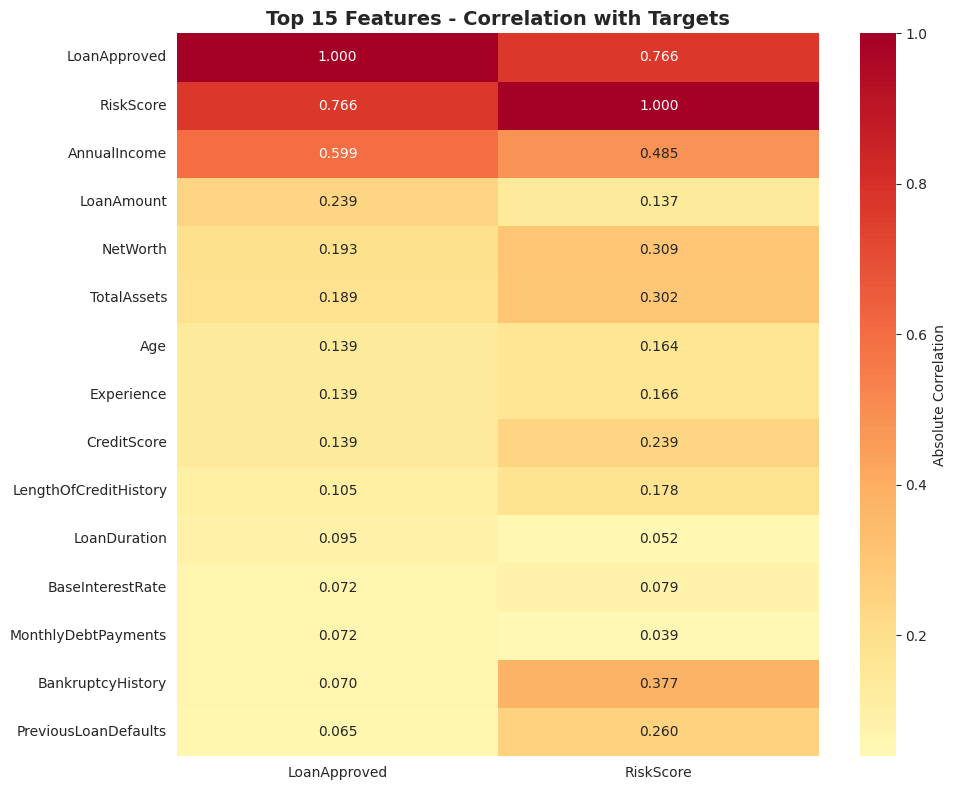

In [46]:
# Plot correlation heatmap with target variables
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlations with targets
correlations = pd.DataFrame({
    'LoanApproved': df_clean[numerical_cols].corrwith(df_clean['LoanApproved']).abs(),
    'RiskScore': df_clean[numerical_cols].corrwith(df_clean['RiskScore']).abs()
}).sort_values('LoanApproved', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlations, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0, cbar_kws={'label': 'Absolute Correlation'}, ax=ax)
ax.set_title(f'Top 15 Features - Correlation with Targets',
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Correlation Insights**

LoanApproved and RiskScore are strongly linked (0.766) — meaning higher risk scores strongly increase the chance a loan is approved.

AnnualIncome has moderate correlation with both targets, confirming income is an important predictor of approval and risk.

NetWorth and TotalAssets show moderate influence on RiskScore but weaker influence on approval.

LoanAmount and CreditScore have small–moderate correlations, meaning they affect outcomes but not as strongly as income- or wealth-based variables.

Features like LoanDuration, MonthlyDebtPayments, Experience, Age have weak correlations, indicating they individually contribute less.

Overall, the heatmap shows that financial strength variables (income, assets, net worth) drive both approval and risk, while demographic features have low impact.



---



##STEP 3: FEATURE ENGINEERING


In [33]:
df_fe = df_clean.copy()

In [34]:
# Calculate monthly income
df_fe['MonthlyIncome'] = df_fe['AnnualIncome'] / 12

In [35]:
# Debt-to-Income Ratio (DTI) - CRITICAL FEATURE
df_fe['DTI_Ratio'] = (df_fe['MonthlyDebtPayments'] + df_fe['MonthlyLoanPayment']) / df_fe['MonthlyIncome']

In [36]:
# Loan-to-Value Ratio (LTV)
df_fe['LTV_Ratio'] = df_fe['LoanAmount'] / (df_fe['TotalAssets'] + 1)  # +1 to avoid division by zero

In [38]:
# Disposable Income
df_fe['DisposableIncome'] = df_fe['MonthlyIncome'] - (df_fe['MonthlyDebtPayments'] + df_fe['MonthlyLoanPayment'])

In [39]:
# Net Worth
df_fe['NetWorth_Calculated'] = df_fe['TotalAssets'] - df_fe['TotalLiabilities']

In [41]:
# Income to Loan Ratio
df_fe['Income_to_Loan'] = df_fe['AnnualIncome'] / df_fe['LoanAmount']

In [42]:
# Debt Burden Score
df_fe['DebtBurden'] = df_fe['TotalLiabilities'] / (df_fe['AnnualIncome'] + 1)

In [43]:
# Financial Health Score (composite)
df_fe['FinancialHealth'] = (
  (df_fe['CreditScore'] / 850) * 0.3 +
  (1 - df_fe['DTI_Ratio'].clip(0, 1)) * 0.3 +
  (df_fe['PaymentHistory'] / 100) * 0.2 +
  (df_fe['LengthOfCreditHistory'] / df_fe['LengthOfCreditHistory'].max()) * 0.2
)

In [44]:
# Risk Flags
df_fe['HighRiskFlag'] = (
  (df_fe['BankruptcyHistory'] > 0) |
  (df_fe['PreviousLoanDefaults'] > 0) |
  (df_fe['NumberOfCreditInquiries'] > 6) |
  (df_fe['CreditScore'] < 600)
).astype(int)

In [45]:
print(f"\nCreated {len([col for col in df_fe.columns if col not in df.columns])} new features")
print("\nNew Features:")
new_features = [col for col in df_fe.columns if col not in df.columns]
for feat in new_features:
  print(f"  - {feat}")


Created 9 new features

New Features:
  - MonthlyIncome
  - DTI_Ratio
  - LTV_Ratio
  - DisposableIncome
  - NetWorth_Calculated
  - Income_to_Loan
  - DebtBurden
  - FinancialHealth
  - HighRiskFlag


STEP 4: DATA PREPROCESSING

In [47]:
df_processed = df_fe.copy()

In [48]:
# Handle date feature
if 'ApplicationDate' in df_processed.columns:
    df_processed['ApplicationDate'] = pd.to_datetime(df_processed['ApplicationDate'])
    df_processed['ApplicationMonth'] = df_processed['ApplicationDate'].dt.month
    df_processed['ApplicationYear'] = df_processed['ApplicationDate'].dt.year
    df_processed['ApplicationDayOfWeek'] = df_processed['ApplicationDate'].dt.dayofweek
    df_processed = df_processed.drop('ApplicationDate', axis=1)

In [49]:
# Encode categorical variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns
le_dict = {}
for col in categorical_cols:
    if col not in ['LoanApproved', 'RiskScore']:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        le_dict[col] = le

## STEP 5:  Loan Approval Classification (Binary)

In [50]:
df = df_processed.copy()

In [51]:
# Prepare features and target
X = df.drop(['LoanApproved', 'RiskScore'], axis=1)
y = df['LoanApproved']

In [52]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")


Training set: 15177 samples
Test set: 3795 samples
Features: 43


In [55]:
# Train Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [56]:
rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [57]:
# Predictions
y_pred = rf_clf.predict(X_test_scaled)
y_pred_proba = rf_clf.predict_proba(X_test_scaled)[:, 1]

In [58]:
# Evaluation
print("\n--- Classification Results ---")
print(classification_report(y_test, y_pred, target_names=['Denied', 'Approved']))


--- Classification Results ---
              precision    recall  f1-score   support

      Denied       0.95      0.92      0.94      2886
    Approved       0.78      0.86      0.82       909

    accuracy                           0.91      3795
   macro avg       0.87      0.89      0.88      3795
weighted avg       0.91      0.91      0.91      3795



✅ Saved: confusion_matrix.png


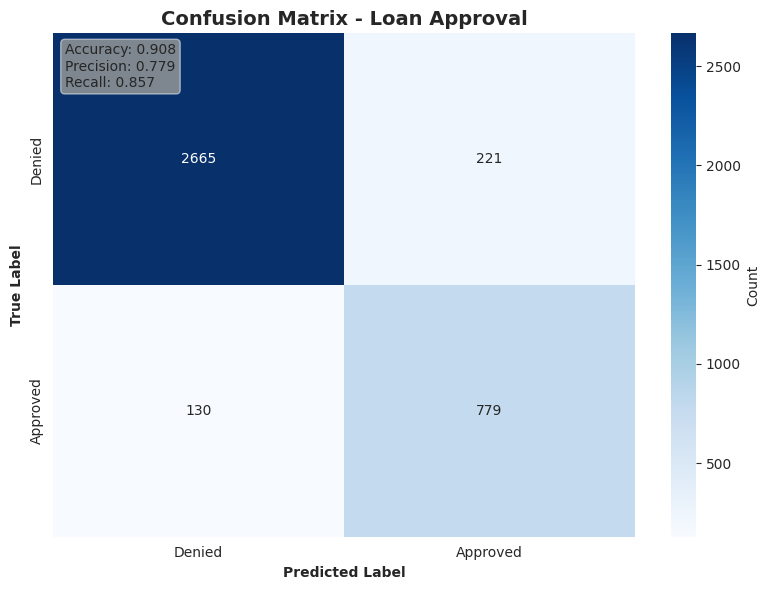

In [60]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'],
            cbar_kws={'label': 'Count'}, ax=ax)

ax.set_xlabel('Predicted Label', fontweight='bold')
ax.set_ylabel('True Label', fontweight='bold')
ax.set_title('Confusion Matrix - Loan Approval', fontsize=14, fontweight='bold')

# Add accuracy metrics
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])

textstr = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()



In [61]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.9649


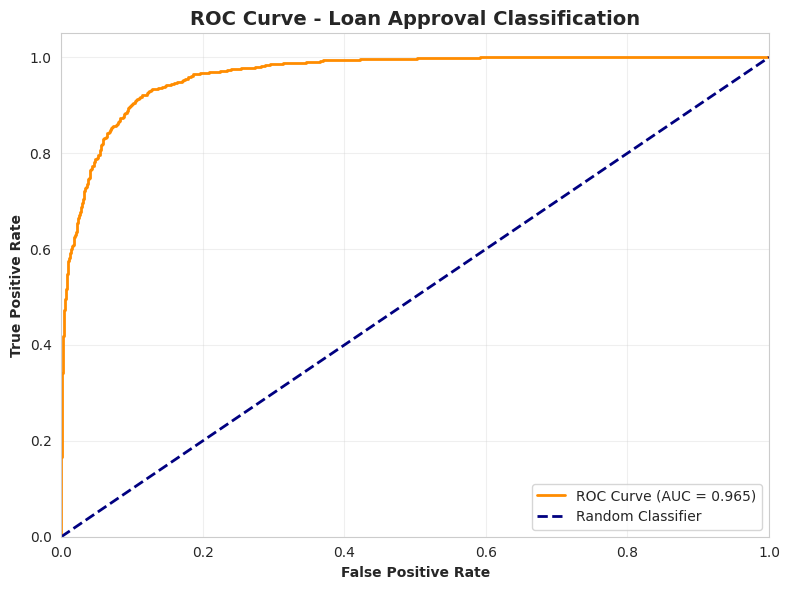

In [62]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2,
        label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('ROC Curve - Loan Approval Classification', fontsize=14, fontweight='bold')
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Loan Approval Classification (RF) – Summary

* Achieved 91% accuracy with strong class-wise performance.

* Denied: F1 = 0.94, high precision/recall → reliable risk detection.

* Approved: F1 = 0.82, good recall (0.86) despite class imbalance.

* Macro F1 = 0.88 → robust, balanced model performance.

* Exhibits strong discriminatory power (ROC-AUC = 0.9649), effectively separating Approved and Denied classes.

* True counts (Denied: 2665, Approved: 779) indicate high predictive reliability. Misclassifications are low (FN = 130, FP = 221), reflecting minimal missed approvals and controlled risk.

* The model handles class imbalance well, with 0.857 recall for the minority Approved class.

* Overall, it demonstrates robust performance, balanced errors, and excellent ranking ability.

---

## STEP 6:  Risk Score Prediction  - Gradient Boosting Regressor

In [63]:
df = df_processed.copy()

In [64]:
# Prepare features and target
X = df.drop(['LoanApproved', 'RiskScore'], axis=1)
y = df['RiskScore']

In [65]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [66]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 15177 samples
Test set: 3795 samples


In [68]:
# Train Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

gb_reg.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=6, min_samples_leaf=5, min_samples_split=10,
                          n_estimators=200, random_state=42)

In [69]:
# Predictions
y_pred = gb_reg.predict(X_test_scaled)

In [70]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

In [71]:
print("\n--- Regression Results ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE:{mape:.4f}")


--- Regression Results ---
RMSE: 3.6242
MAE: 2.8826
R² Score: 0.7786
MAPE:0.0584


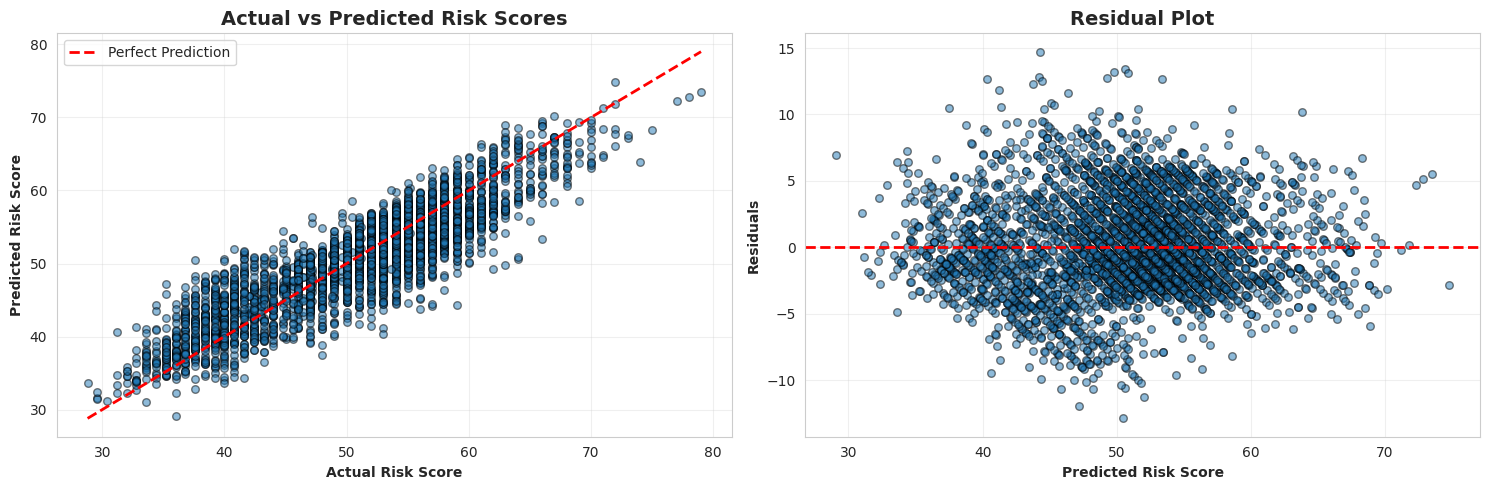

In [72]:
# Plot actual vs predicted for regression
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.5, edgecolors='k', s=30)
axes[0].plot([y_test.min(), y_test.max()],
              [y_test.min(), y_test.max()],
              'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Risk Score', fontweight='bold')
axes[0].set_ylabel('Predicted Risk Score', fontweight='bold')
axes[0].set_title('Actual vs Predicted Risk Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, edgecolors='k', s=30)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Risk Score', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

The Actual vs Predicted Risk Scores plot shows predictions closely aligned along the perfect-fit line, indicating strong model performance with low systematic bias.

The Residual Plot displays residuals centered around zero with no clear pattern, suggesting homoscedasticity and that the Gradient Boosting Regressor generalizes well without evident underfitting or overfitting.

###  Risk Score Prediction - Summary
* The model predicts Risk Scores with strong accuracy, achieving RMSE = 3.6242 and MAE = 2.8826, indicating that predictions deviate moderately from actual values relative to the score range (28.8–84.0, mean ≈ 50.77).
* The R² of 0.7786 demonstrates that ~78% of variance in Risk Score is captured, while a low MAPE of 5.84% shows minimal relative error, confirming reliable predictive performance across the observed distribution.

---

## STEP 7: MODEL EXPLAINABILITY

SHAP explainability is applied to make both models transparent:

1. explain_predictions() generates global explanations by computing SHAP values across the test set and ranking features by their average contribution. This shows which factors most influence model decisions overall.

2. explain_individual_prediction() provides local explanations by breaking down a single prediction into feature-level SHAP contributions. This shows how each feature pushed the decision higher or lower.

Together, these explain why each loan/risk outcome was made, enabling stakeholders to clearly understand and trust the model's decisions.

In [73]:
def explain_predictions(model, X_test, feature_names, model_type='classification'):
    """Generate SHAP explanations for model predictions"""
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for a sample
    sample_size = min(500, X_test.shape[0])
    X_sample = X_test[:sample_size]
    shap_values = explainer.shap_values(X_sample)

    if model_type == 'classification':
        if isinstance(shap_values, list):
            shap_values_plot = shap_values[1]
        elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
            shap_values_plot = shap_values[:, :, 1]
        else:
            shap_values_plot = shap_values
    else:
        shap_values_plot = shap_values

    print(f"\nSHAP values calculated for {sample_size} samples")

    # Summary of most important features
    feature_importance = np.abs(shap_values_plot).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': list(feature_names),
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nGlobal Feature Importance (SHAP)")
    print(feature_importance_df.head(15))

    return explainer, shap_values_plot, X_sample, feature_importance_df

In [74]:
def explain_individual_prediction(model, explainer, X_sample, feature_names, idx=0):
    """Explain individual prediction"""
    print(f"\nIndividual Prediction Explanation (Sample #{idx}")

    sample = X_sample[idx:idx+1]
    prediction = model.predict(sample)[0]

    print(f"Prediction: {prediction:.4f}")

    shap_values = explainer.shap_values(sample)

    if isinstance(shap_values, list):
        shap_values_for_plot = shap_values[1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_values_for_plot = shap_values[:, :, 1]
    else:
        shap_values_for_plot = shap_values

    # Get top contributing features
    contributions = pd.DataFrame({
        'feature': list(feature_names),
        'value': sample[0],
        'shap_value': shap_values_for_plot[0]
    }).sort_values('shap_value', key=abs, ascending=False)

    print("\nTop 10 Contributing Features:")
    print(contributions.head(10))
    print("\n")

    return contributions

In [75]:
print("\nClassification Model Explainability")
clf_explainer, clf_shap, clf_sample, clf_shap_importance = explain_predictions(rf_clf, X_test_scaled, X.columns, 'classification')

print("\nRegression Model Explainability")
reg_explainer, reg_shap, reg_sample, reg_shap_importance = explain_predictions(gb_reg, X_test_scaled, X.columns, 'regression')


Classification Model Explainability

SHAP values calculated for 500 samples

Global Feature Importance (SHAP)
                  feature  importance
36         Income_to_Loan    0.129377
1            AnnualIncome    0.067275
31          MonthlyIncome    0.061477
34       DisposableIncome    0.039878
38        FinancialHealth    0.027704
6              LoanAmount    0.026177
33              LTV_Ratio    0.025752
32              DTI_Ratio    0.023707
28           InterestRate    0.016688
26               NetWorth    0.015682
35    NetWorth_Calculated    0.015415
37             DebtBurden    0.014767
22            TotalAssets    0.013815
29     MonthlyLoanPayment    0.013157
19  LengthOfCreditHistory    0.011868

Regression Model Explainability

SHAP values calculated for 500 samples

Global Feature Importance (SHAP)
                      feature  importance
36             Income_to_Loan    1.423911
39               HighRiskFlag    1.385426
15          BankruptcyHistory    1.235403
1     

The SHAP analysis shows that both models rely on financially intuitive drivers.

1. For the classification model, loan approval decisions are primarily influenced by borrower affordability metrics—Income-to-Loan, Annual/Monthly Income, Disposable Income, LTV and DTI ratios—indicating that approval outcomes are strongly tied to repayment capacity and financial stability.

2. For the regression model, risk score predictions are additionally shaped by HighRiskFlag, BankruptcyHistory, PreviousLoanDefaults and EmploymentStatus, showing that past credit behavior and financial history significantly increase predicted risk.

In [76]:
# Example individual explanations
print("\n--- Example: Approved Loan Explanation ---")
approved_idx = np.where(rf_clf.predict(X_test_scaled) == 1)[0][0]
explain_individual_prediction(rf_clf, clf_explainer, clf_sample, X.columns,
                              min(approved_idx, clf_sample.shape[0]-1))

print("\n--- Example: Denied Loan Explanation ---")
denied_idx = np.where(rf_clf.predict(X_test_scaled) == 0)[0][0]
explain_individual_prediction(rf_clf, clf_explainer, clf_sample, X.columns,
                              min(denied_idx, clf_sample.shape[0]-1))


--- Example: Approved Loan Explanation ---

Individual Prediction Explanation (Sample #2
Prediction: 1.0000

Top 10 Contributing Features:
                 feature     value  shap_value
36        Income_to_Loan  0.197742    0.087688
1           AnnualIncome -0.207677   -0.069084
31         MonthlyIncome -0.207677   -0.058161
17  PreviousLoanDefaults  2.973619   -0.041521
34      DisposableIncome  0.252774   -0.038916
6             LoanAmount -0.809117    0.034760
33             LTV_Ratio -0.602310    0.033619
32             DTI_Ratio -0.265974    0.025886
28          InterestRate -0.105501    0.024455
38       FinancialHealth  0.753371    0.022796



--- Example: Denied Loan Explanation ---

Individual Prediction Explanation (Sample #0
Prediction: 0.0000

Top 10 Contributing Features:
            feature     value  shap_value
36   Income_to_Loan -0.238019   -0.161668
6        LoanAmount  0.510689   -0.067549
33        LTV_Ratio  0.906696   -0.039792
31    MonthlyIncome  0.410755    0.

,feature,value,shap_value
36,Income_to_Loan,-0.238019,-0.161668
6,LoanAmount,0.510689,-0.067549
33,LTV_Ratio,0.906696,-0.039792
31,MonthlyIncome,0.410755,0.030990
1,AnnualIncome,0.410755,0.030897
0,Age,-1.871873,-0.028067
38,FinancialHealth,0.759546,0.024503
5,Experience,-1.548463,-0.021996
37,DebtBurden,0.050082,-0.021288
26,NetWorth,-0.604255,-0.018090


The SHAP explanations show the exact factors driving each loan decision.

* For the approved case, affordability indicators (Income-to-Loan, LoanAmount, LTV and DTI ratios) contributed positively and outweighed smaller negative effects, pushing the prediction toward approval.

* For the denied case, the same affordability metrics contributed strongly in the negative direction, indicating high loan burden and risk, resulting in rejection despite some positive income and financial health signals.

Overall, the model’s decisions align with logical credit-risk reasoning and are fully interpretable.

In [79]:
def plot_shap_summary(shap_values, X_sample, feature_names, title):
    """Plot SHAP summary"""
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                     show=False, max_display=15)
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    plt.show()

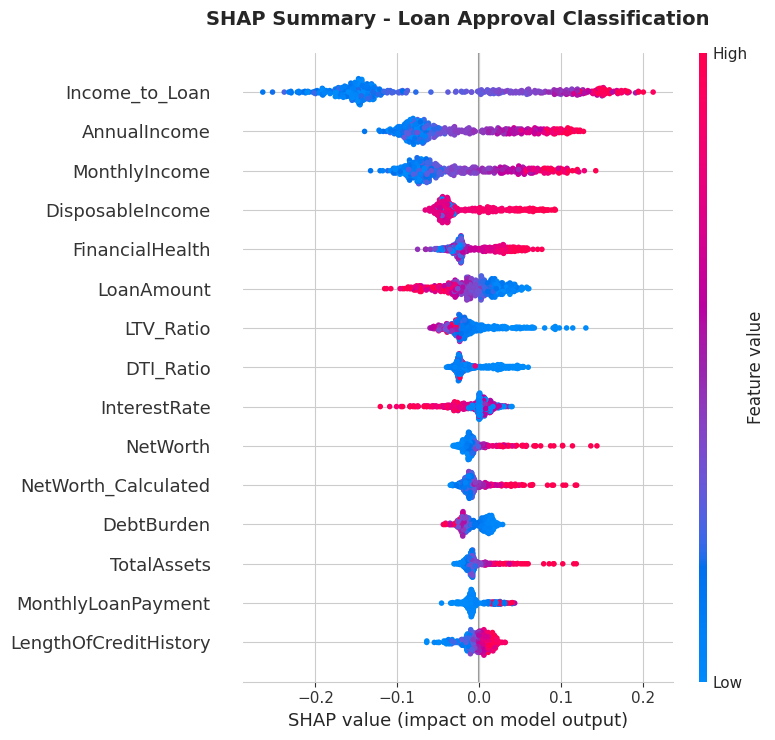

In [80]:
plot_shap_summary(clf_shap, clf_sample,  X.columns,
                     'SHAP Summary - Loan Approval Classification')

Loan Approval Classification — SHAP Summary

The model approves loans when affordability indicators are strong. High Income_to_Loan, Annual/Monthly Income, and DisposableIncome push predictions toward approval, while high LoanAmount, LTV_Ratio, and DTI_Ratio push them toward rejection. The pattern confirms that decisions are driven mainly by repayment capacity and leverage.

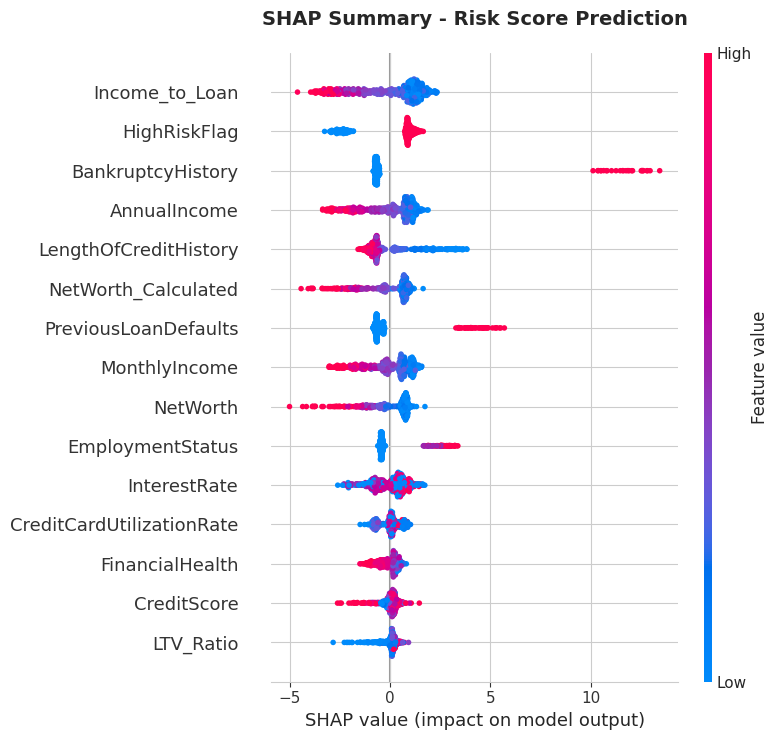

In [81]:
plot_shap_summary(reg_shap, reg_sample,  X.columns,
                     'SHAP Summary - Risk Score Prediction')

Risk Score Prediction — SHAP Summary

The model increases risk scores when historical risk indicators are present. HighRiskFlag, BankruptcyHistory, and PreviousLoanDefaults contribute strongly to higher risk, while higher income and net worth decrease risk. This shows the model balances both credit history and current financial strength when scoring risk.